# ZNF462
[Weiss-Kruszka syndrome (WSKA)](https://omim.org/entry/618619) is caused by heterozygous mutation in the [ZNF462](https://omim.org/entry/617371) gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### ZNF462
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZNF462.

In [2]:
gene_symbol = 'ZNF462'
mane_tx_id = 'NM_021224.6'
mane_protein_id = 'NP_067047.4' # zinc finger protein 462 isoform 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from pyphetools.visualization import PhenopacketIngestor
ingestor = PhenopacketIngestor(indir="../../../phenopacket-store/notebooks/ZMYM3/phenopackets")
phenopackets = ingestor.get_phenopacket_list()
print(f'Loaded {len(phenopackets)} phenopackets')


from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 39 phenopackets
[pyphetools] Ingested 33 GA4GH phenopackets.
Loaded 33 phenopackets
Individuals Processed: 100%|██████████| 33/33 [00:43<00:00,  1.31s/individuals]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #9
    individual
     warnings:
     ·`time_element` is in currently unsupported format `ontology_class`
     ·`time_element` is in currently unsupported format `ontology_class`


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(phenopackets=phenopackets,cohort_creator=cohort_creator,)

Individuals Processed: 100%|██████████| 39/39 [00:50<00:00,  1.30s/individuals]


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Delayed speech and language development,HP:0000750,29
Motor delay,HP:0001270,21
Intellectual disability,HP:0001249,20
Autistic behavior,HP:0000729,15
Hypospadias,HP:0000047,8
Cupped ear,HP:0000378,8
Short stature,HP:0004322,7
Sleep abnormality,HP:0002360,6
Deeply set eye,HP:0000490,6
Microcephaly,HP:0000252,6


ValueError: The transcript annotation for NM_021224.6 was not found!

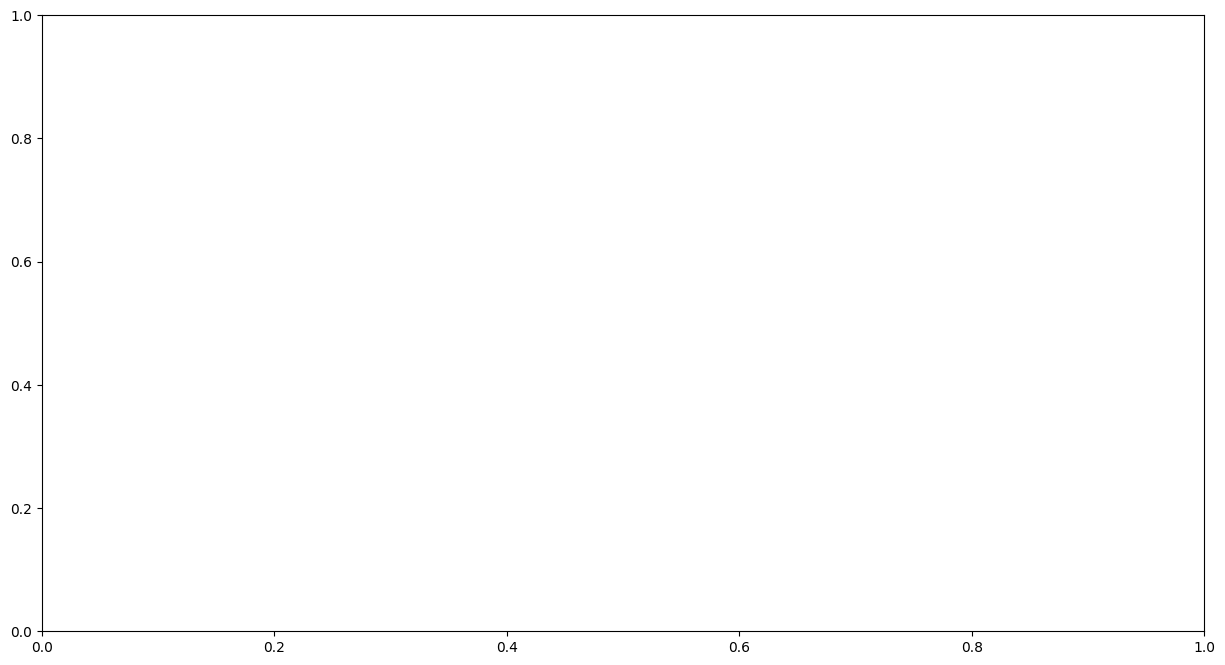

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="SLC31A1",
        uniprot_json="Q96JM2.json",
        protein_length=2506,
)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Strategy
All published variants belong to categories that are often considered to be loss of function (FRAMESHIFT_VARIANT, TRANSCRIPT_ABLATION, STOP_GAINED, SPLICE_ACCEPTOR_VARIANT). We will test transcript ablation and the most commonly reported variant.

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

abl_pred = VariantPredicates.variant_effect(VariantEffect.TRANSCRIPT_ABLATION, mane_tx_id)
gt_predicate = autosomal_dominant(abl_pred)

In [15]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis
from gpsea.view import MtcStatsViewer


pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,8
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF04,Skipping term because all genotypes have same HPO observed proportions,40
HMF05,Skipping term because one genotype had zero observations,10
HMF06,Skipping term with less than 7 observations (not powered for 2x2),24
HMF08,Skipping general term,32


In [16]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         HOM_REF           HET  \
                                                     Count Percent Count   
Delayed speech and language development [HP:000...   18/30     60%   0/4   
Prominent metopic ridge [HP:0005487]                 14/31     45%   0/4   
Hearing impairment [HP:0000365]                       7/29     24%   3/5   
Low-set ears [HP:0000369]                             6/26     23%   2/4   
Intellectual disability [HP:0001249]                 11/28     39%   3/4   
Feeding difficulties [HP:0011968]                    13/28     46%   1/6   
Ventricular septal defect [HP:0001629]                4/29     14%   1/3   
Exaggerated cupid's bow [HP:0002263]                 16/29     55%   3/4   
Highly arched eyebrow [HP:0002553]                   18/31     58%   2/5   
Autistic behavior [HP:0000729]                       10/31     32%   1/7   
Broad philtrum [HP:0000289]                          17/30     57%   5/7   
Motor delay [HP:0001270]                             14/30     47%   2/4   
Global developmental delay [HP:0001263]              23/30     77%   6/7   
Ptosis [HP:0000508]                                  27/31     87%   5/6   
Epicanthus [HP:0000286]                              12/30     40%   1/4   
Downslanted palpebral fissures [HP:0000494]          17/30     57%   2/4   
Anteverted nares [HP:0000463]                        14/30     47%   3/6   
Bulbous nose [HP:0000414]                            14/30     47%   3/6   
Hypotonia [HP:0001252]                               12/31     39%   2/6   
Agenesis of corpus callosum [HP:0001274]              6/22     27%   1/3   

What is the genotype group                                                     \
                                                   Percent Corrected p values   
Delayed speech and language development [HP:000...      0%           0.784889   
Prominent metopic ridge [HP:0005487]                    0%           0.920304   
Hearing impairment [HP:0000365]                        60%           0.920304   
Low-set ears [HP:0000369]                              50%           1.000000   
Intellectual disability [HP:0001249]                   75%           1.000000   
Feeding difficulties [HP:0011968]                      17%           1.000000   
Ventricular septal defect [HP:0001629]                 33%           1.000000   
Exaggerated cupid's bow [HP:0002263]                   75%           1.000000   
Highly arched eyebrow [HP:0002553]                     40%           1.000000   
Autistic behavior [HP:0000729]                         14%           1.000000   
Broad philtrum [HP:0000289]                            71%           1.000000   
Motor delay [HP:0001270]                               50%           1.000000   
Global developmental delay [HP:0001263]                86%           1.000000   
Ptosis [HP:0000508]                                    83%           1.000000   
Epicanthus [HP:0000286]                                25%           1.000000   
Downslanted palpebral fissures [HP:0000494]            50%           1.000000   
Anteverted nares [HP:0000463]                          50%           1.000000   
Bulbous nose [HP:0000414]                              50%           1.000000   
Hypotonia [HP:0001252]                                 33%           1.000000   
Agenesis of corpus callosum [HP:0001274]               33%           1.000000   

What is the genotype group                                    
                                                    p values  
Delayed speech and language development [HP:000...  0.039244  
Prominent metopic ridge [HP:0005487]                0.133422  
Hearing impairment [HP:0000365]                     0.138046  
Low-set ears [HP:0000369]                           0.283525  
Intellectual disability [HP:0001249]                0.295133  
Feeding difficulties [HP:0011968]                   0.363631  
Ventricular septal defect [HP:0001629]  

In [17]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex of the individual                              FEMALE           MALE  \
                                                    Count Percent  Count   
Delayed speech and language development [HP:000...    2/9     22%  16/25   
Highly arched eyebrow [HP:0002553]                   8/10     80%  11/25   
Ventriculomegaly [HP:0002119]                         2/7     29%   1/18   
Hearing impairment [HP:0000365]                      4/10     40%   4/22   
Feeding difficulties [HP:0011968]                     5/9     56%   8/23   
Hypotonia [HP:0001252]                               5/10     50%   8/25   
Autistic behavior [HP:0000729]                       2/10     20%   9/25   
Motor delay [HP:0001270]                              3/9     33%  13/25   
Intellectual disability [HP:0001249]                  5/9     56%   9/23   
Anteverted nares [HP:0000463]                         5/9     56%  10/25   
Bulbous nose [HP:0000414]                             5/9     56%  10/25   
Ventricular septal defect [HP:0001629]                2/8     25%   3/24   
Global developmental delay [HP:0001263]               6/9     67%  20/25   
Downslanted palpebral fissures [HP:0000494]           6/9     67%  13/25   
Broad philtrum [HP:0000289]                           6/9     67%  14/25   
Ptosis [HP:0000508]                                  9/10     90%  21/25   
Epicanthus [HP:0000286]                               3/9     33%  10/25   
Exaggerated cupid's bow [HP:0002263]                  5/8     62%  14/25   
Low-set ears [HP:0000369]                             2/8     25%   5/21   
Agenesis of corpus callosum [HP:0001274]              2/7     29%   5/18   

Sex of the individual                                                          \
                                                   Percent Corrected p values   
Delayed speech and language development [HP:000...     64%           0.711758   
Highly arched eyebrow [HP:0002553]                     44%           0.711758   
Ventriculomegaly [HP:0002119]                           6%           0.840052   
Hearing impairment [HP:0000365]                        18%           0.840052   
Feeding difficulties [HP:0011968]                      35%           0.840052   
Hypotonia [HP:0001252]                                 32%           0.840052   
Autistic behavior [HP:0000729]                         36%           0.840052   
Motor delay [HP:0001270]                               52%           0.840052   
Intellectual disability [HP:0001249]                   39%           0.840052   
Anteverted nares [HP:0000463]                          40%           0.840052   
Bulbous nose [HP:0000414]                              40%           0.840052   
Ventricular septal defect [HP:0001629]                 12%           0.938821   
Global developmental delay [HP:0001263]                80%           0.938821   
Downslanted palpebral fissures [HP:0000494]            52%           0.938821   
Broad philtrum [HP:0000289]                            56%           0.938821   
Ptosis [HP:0000508]                                    84%           1.000000   
Epicanthus [HP:0000286]                                40%           1.000000   
Exaggerated cupid's bow [HP:0002263]                   56%           1.000000   
Low-set ears [HP:0000369]                              24%           1.000000   
Agenesis of corpus callosum [HP:0001274]               28%           1.000000   

Sex of the individual                                         
                                                    p values  
Delayed speech and language development [HP:000...  0.052280  
Highly arched eyebrow [HP:0002553]                  0.071176  
Ventriculomegaly [HP:0002119]                       0.179565  
Hearing impairment [HP:0000365]                     0.218210  
Feeding difficulties [HP:0011968]                   0.426935  
Hypotonia [HP:0001252]                              0.443707  
Autistic behavior [HP:0000729]          

# Summary
No statistically significant genotype phenotype association was identified.